In [1]:
%matplotlib widget
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.signal import find_peaks

# 设置中文字体为 wqy
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']  # 使用文泉驿正黑字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [2]:
def calculate_threshold(red_channel):
    hist = cv.calcHist([red_channel], [0], None, [256], [0, 256]).flatten()
    peaks, _ = find_peaks(hist)
    sorted_peaks = sorted(peaks, key=lambda x: hist[x], reverse=True)
    second_peak_index = sorted_peaks[1]
    min_val_after_peak = np.argmin(hist[second_peak_index:]) + second_peak_index
    return min_val_after_peak


def segment_image(src, threshold, kernel_size):
    _, src_bin = cv.threshold(src, threshold, 255, cv.THRESH_BINARY)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)
    src_bin = cv.morphologyEx(src_bin, cv.MORPH_OPEN, kernel)
    src_bin = cv.morphologyEx(src_bin, cv.MORPH_CLOSE, kernel)
    coords = cv.findNonZero(src_bin)
    return cv.boundingRect(coords)


def crop_to_bbox(frame, bbox):
    x, y, w, h = bbox
    return frame[y : y + h, x : x + w]


def process_image(frame, previous_bbox_area):
    red_channel = frame[:, :, 2]
    threshold = calculate_threshold(red_channel)
    kernel_size = (5, 5)
    bbox = segment_image(red_channel, threshold, kernel_size)
    current_bbox_area = bbox[2] * bbox[3]

    if previous_bbox_area > 0 and current_bbox_area > previous_bbox_area * 1.5:
        kernel_size = (7, 7)
        bbox = segment_image(red_channel, threshold, kernel_size)

    cropped_frame = crop_to_bbox(frame, bbox)
    return cropped_frame, bbox[2] * bbox[3]

In [3]:
# 读取视频文件并加载前50帧到内存中
video_path = "真实场景.mp4"
cap = cv.VideoCapture(video_path)
frame_count = min(10, int(cap.get(cv.CAP_PROP_FRAME_COUNT)))  # 只读取前50帧
frames = []

# 使用 tqdm 显示进度条
for _ in tqdm(range(frame_count), desc="Loading frames"):
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)
cap.release()

Loading frames:   0%|          | 0/10 [00:00<?, ?it/s]

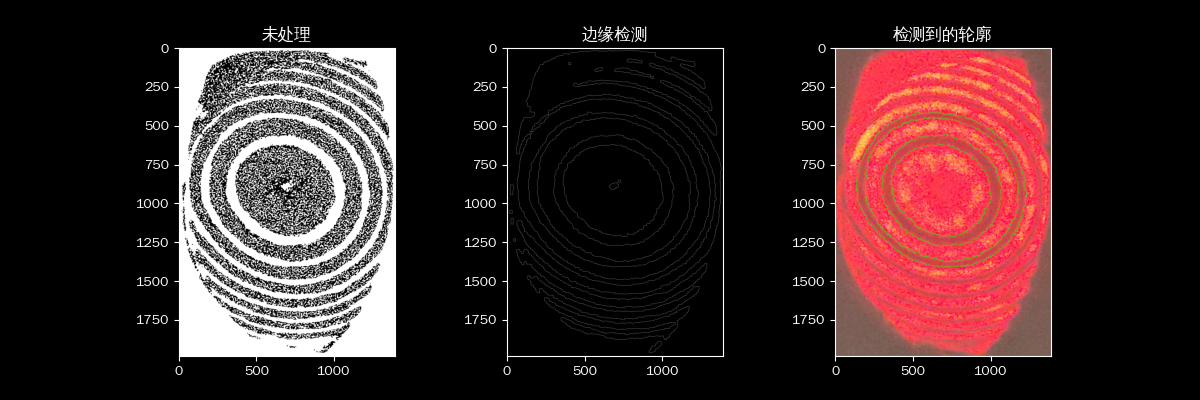

In [4]:
# 清空所有现有的图形
plt.close("all")

frame = frames[2]  # 选择第6帧
cropped_frame, bbox_area = process_image(frame, 0)

# 提取红色频道
red_channel = cropped_frame[:, :, 2]

# 计算最大值作为阈值
max_val = np.max(red_channel)
threshold = max_val

# 根据阈值进行二值化处理
binary_image = (red_channel != threshold).astype(np.uint8) * 255

# 一次13x13处理
kernel = cv.getStructuringElement(cv.MORPH_RECT, (13, 13))
processed_image_13x13 = cv.morphologyEx(binary_image, cv.MORPH_OPEN, kernel)
processed_image_13x13 = cv.morphologyEx(processed_image_13x13, cv.MORPH_CLOSE, kernel)

# 使用Canny边缘检测算法
median = np.median(processed_image_13x13)
edges = cv.Canny(processed_image_13x13, 0.66 * median, 1.33 * median)

# 轮廓发现
contours, _ = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# 计算每个轮廓的面积
contour_areas = [(contour, cv.contourArea(contour)) for contour in contours]

min_length = 500  # 设置最小长度阈值
circularity_threshold = 0.7  # 设置圆形度阈值

filtered_contours = []
for contour in contours:
    area = cv.contourArea(contour)
    perimeter = cv.arcLength(contour, True)
    if perimeter < min_length:
        continue
    circularity = 4 * np.pi * (area / (perimeter * perimeter))
    if circularity >= circularity_threshold:
        filtered_contours.append(contour)

# 在 cropped_frame 上绘制过滤和合并后的轮廓
cv.drawContours(cropped_frame, filtered_contours, -1, (0, 255, 0), 5)  # 绿色轮廓

# 绘制原始图像和边缘检测后的图像
plt.figure(figsize=(12, 4))

# 原始二值化图像
plt.subplot(1, 3, 1)
plt.imshow(binary_image, cmap="gray")
plt.title("未处理")

# 边缘检测后的图像
plt.subplot(1, 3, 2)
plt.imshow(edges, cmap="gray")
plt.title("边缘检测")

# 在 cropped_frame 上绘制检测到的轮廓
plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(cropped_frame, cv.COLOR_BGR2RGB))  # 转换为 RGB 显示
plt.title("检测到的轮廓")

plt.show()